# Etude sur la competition écologique

Ce fichier a pour objectif l'étude des subtilités liées à la réalisation des compétitions écologiques déterministes. Il contient à la fois du texte explicatif et du code Python pour illustrer les résultats.

# Study on ecological competition
This file aims at studying the subtleties related to the realization of deterministic ecological competitions. It contains both explanatory text and Python code to illustrate the results.


In [1]:
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/evolutions.py

import time
import itertools as it

# real formatting in numpy and pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# usual sets of strategies
bag20 = getClassicals()[0:20]
bag4 = [Periodic('CCD','per_ccd'), Periodic('DDC','per_ddc'), Prober(),Mistrust()]
bag5 = [Periodic('CCD','per_ccd'), Periodic('DDC','per_ddc'), Prober(), SoftMajority(),HardMajority()]
bag6 = [Prober(), Periodic('C','allC'), Mistrust(), Periodic('D','allD'), Tft(), Gradual()]
bag11= getClassicals()[0:9]+[Prober(),Gradual()]
bagDyson=[Proba('C',1.0,0.3,0.7,0.0) , Proba('C',0.9,0.7,0.2,0.1), Proba('C',0.9,0.5,0.5,0.3), Proba('C',0.8,0.1,0.6,0.0), Proba('C',0.85,0.075,0.7,0)] 

# example of a classical tournament
bag = bag6
m1 = m1 = Tournament(g,bag,length=100)
m1.run()
m1.matrix


,prober,gradual,tft,mistrust,allC,allD,Total
prober,104,299,299,295,496,98,1591
gradual,299,300,300,296,300,89,1584
tft,299,300,300,250,300,99,1548
mistrust,300,301,250,100,302,100,1353
allC,6,300,300,297,300,0,1203
allD,108,144,104,100,500,100,1056


## Principe général

## General principle

Soit $S$ un vecteur de $n$ strategies.
Soit $Scores$ la matrice (n x n) des scores des rencontres 2 à 2 telle que Scores($s_i$,$s_j$) = score obtenu par la stratégie $s_i$ quand elle rencontre $s_j$
Soit $P$ un vecteur de taille $n$ de populations tel que P($s_i$) = population de la stratégie $s_i$  et tel que base=$\Sigma(P)$ 

$Scores.dot(P)$ correspond au vecteur des scores obtenus par une stratégie $s_i$ contre toutes les autres, y compris elle-même. $P * Scores.dot(P)$ correspond au vecteur des scores obtenus par toute la population de $s_i$ contre toutes 
les autres familles, appelé vecteur de fitness

Dans la forme générale , 
$$
fitnessF = P_t \times (Scores * P_t) \\
P_{t+1} = (base . fitnessF) // sum(fitnessF)
$$

($*$ designe le produit d'une matrice par un vecteur. $\times$ désigne le produit terme à terme de 2 vecteurs tandis que  '.' désigne le produit d'un scalaire avec chacune des composantes du vecteur et $//$ chacune des composantes d'un vecteur divisé ( division entiere) par un scalaire).

La compétition écologique est donc une itération de ce processus.

Attention au fait que les arrondis ne garantissent pas une population totale constante. Chaque $P_t$ ne fait donc pas exactement la même somme. Pour éviter une dérive des populations, la base est calculée une fois pour toutes sur le vecteur de départ et non pas sur la population à t-1.


In [2]:
nbstrats=len(bag)
scores = m1.matrix.iloc[0:nbstrats,0:nbstrats].values
population=np.array([100]*nbstrats)
base=sum(population)
for i in range(10) :
    print(population)
    fitness = population*np.dot(scores,population)
    population = (base*fitness)//sum(fitness)

[100 100 100 100 100 100]
[114 114 111  97  86  76]
[125 129 123  94  73  53]
[132 145 135  90  61  34]
[134 160 146  86  51  20]
[132 175 156  81  42  11]
[128 189 165  76  35   5]
[122 201 172  70  29   2]
[116 213 179  65  24   0]
[109 224 185  60  20   0]


Si on souhaite calculer l'évolution sur des pourcentages, on considère alors que $P$ est un vecteur de réels compris entre 0 et 1, et que $\Sigma(P)=1$.
$base$ étant égal à 1, la règle de 3 se simplifie, et la division devient cette fois une division sur les réels.

$$ 
fitnessF = P_t \times Scores * P_t\\
P_{t+1} = fitnessF / sum(fitnessF)
$$

($/$ correspond cette fois à la division réelle).

In [3]:
population=np.array([1/nbstrats]*nbstrats)

for i in range(10) :
    print(population)
    fitness = population*np.dot(scores,population)
    population = fitness/sum(fitness)

[0.167 0.167 0.167 0.167 0.167 0.167]
[0.191 0.190 0.186 0.162 0.144 0.127]
[0.210 0.215 0.206 0.158 0.123 0.089]
[0.221 0.241 0.225 0.152 0.104 0.057]
[0.225 0.266 0.243 0.144 0.087 0.034]
[0.222 0.291 0.259 0.136 0.073 0.019]
[0.215 0.313 0.274 0.127 0.061 0.010]
[0.206 0.334 0.286 0.119 0.051 0.005]
[0.195 0.353 0.297 0.110 0.043 0.002]
[0.184 0.370 0.307 0.102 0.036 0.001]


## Deux variantes :
## Two variants :

### 1 - On ne joue pas contre soi-même : 
### 1 - You don't play against yourself: 
On note que dans le processus décrit précédemment, chaque stratégie joue contre elle-même, ce qui est une simplification sans doute abusive. Afin d'effectuer un calcul plus rigoureux, chaque stratégie joue contre tout le monde, y compris ses semblables, mais pas elle-même. Il faut donc au moment du calcul du fitness, et juste avant de multiplier par l'ensemble de la population, retirer pour chaque stratégie le score qu'elle obtient contre elle-même (donc sur la diagonale de la matrice obtenue).
Le calcul est donc décomposé en 


$$
fitnessI = (Scores * P_t) \\
fitnessI = fitnessI - (scores[i,i]) \\
fitnessF = P_t \times fitnessI \\
P_{t+1} = (base . fitnessF) // sum(fitnessF)
$$


**C'est ce calcul que nous faisons depuis 30 ans !**


In [4]:
population=np.array([100]*nbstrats)
base=sum(population)
for i in range(10) :
    print(population)
    fitness = np.dot(scores,population)
    # On enleve le score que j'ai obtenu contre moi-même
    fitness -= np.diag(scores)
    fitness = population * fitness
    population = (base*fitness)//sum(fitness)

[100 100 100 100 100 100]
[114 113 111  97  86  76]
[125 128 123  94  73  53]
[132 144 135  91  61  34]
[134 159 146  87  51  20]
[133 174 156  82  42  11]
[129 187 165  76  35   5]
[123 200 173  71  29   2]
[116 211 179  65  24   0]
[110 222 185  60  20   0]


On notera que même sur 10 générations, on n'obtient pas le même résultat qu'avec le calcul précédent. C'est "quasi" le même, mais ce n'est pas "exactement le même."

**Cette variante n'a pas vraiment de sens avec un calcul sur les "pourcentages" puisqu'on n'est plus au niveau de l'individu.**

### 2 - On ne joue pas contre ses semblables.
### 2 - You don't play against your own kind.

Une autre position philosophique toute aussi rationnelle serait de considérer que non seulement on ne joue pas contre soi-même, mais qu'en plus on ne se bat pas avec ses semblables.

Une manière élégante d'effectuer ce calcul consiste à annuler les scores que chaque stratégie fait contre elle même, et donc mettre à zero la diagonale de la matrice des scores.
On peut alors garder le même processus de calcul que précédemment.

**C'est ce que l'on appelle m2sr (ou modèle communautaire)**

In [5]:
# We put zeros on the diagonal, score against myself.
np.fill_diagonal(scores, 0)
population=np.array([100]*nbstrats)
base=sum(population)
for i in range(10) :
    print(population)
    fitness = population*np.dot(scores,population)
    population = (base*fitness)//sum(fitness)

[100 100 100 100 100 100]
[125 108 105 105  75  80]
[144 116 110 110  59  58]
[157 123 114 115  48  39]
[165 130 118 119  40  25]
[169 135 121 123  34  15]
[170 139 124 126  29   9]
[170 143 126 128  26   5]
[169 146 127 129  23   2]
[168 148 129 131  21   1]


Là encore, on notera que même sur 10 générations, on n'obtient pas le même résultat qu'avec le calcul précédent ce qui était attendu. Cette fois on constate que les résultats sont clairement différents.

On constate notamment qu'avec le calcul classique l'agorithme converge vers un point fixe qui dépend des pop de depart , tandis qu'avec **m2sr** il y a quasiment toujours un point fixe indépendamment des populations de départ. Ces propriétés seront étudiées statistiquement un peu plus loin dans cette feuille.

Cette variante peut aussi bien être implémentée sur les populations entières que sur la version "pourcentages".

### 3 - La résilience de l'ancienne population.
### 3 - The resilience of the previous population.

Dans les algorithmes précédents, la nouvelle population est directement issue des performances obtenues. Une position plus naturaliste consiste à considérer que les anciens individus ne disparaissent pas tous tout de suite pour faire place aux nouveaux, mais seulement dans une certaine proposition. Ce que nous appellerons la résilience de l'ancienne population.

La prise en compte de cette résilience peut se faire simplement au moment du calcul de la nouvelle population par la règle de 3. Si on considère que resilience à 0 correspond au cas classique, et resilience à 1 correspond à une population qui ne change jamais, Cela devient

- Pour la version *Pourcentages*

``
        population = (resilience*population) + (1-resilience)*(fitness/sum(fitness))
``
- Pour la version *Entiers*

``
        population = (resilience*population) + (1-resilience)*(base*fitness)//sum(fitness)
``

### Conclusion
En conclusion, on a donc 5 algorithmes : 
- le cas général (clair, propre, mathématisé) sur les populations entieres ou sur les "pourcentages", 
- la variante "pas contre moi-même" (plus rationnelle mais moins mathématisée et code plus complexe) mais uniquement sur les populations entieres, 
- la variante "pas contre mes semblables" pouvant être faite sur des populations entieres ou des "pourcentages".

On pourrait espérer un code unique pour ces 3 procédures (et 5 cas), mais cela nécessite du coup des IF (des tests) à chaque itération, ce qui ralentit fortement l'execution. Par ailleurs, les types de données utilisés ne sont pas les mêmes. On pourrait croire que le type `Reel` généralise l'ensemble, mais des entiers codés dans des variables `Reel` ne permettent pas d'aller aussi loin dans le calcul exact.
Pour une execution rapide on préfèrera un code spécifique, pour faciliter la maintenance on privilégiera un code unique avec différents tests

## Le calcul de la coopération

La matrice de coopération contient le nombre de fois où une stratégie $s_i$ a coopéré avec une stratégie $s_j$.
En effectuant le même calcul que sur les scores, on obtient le nombre de coopérations global.
Ce calcul dépendant de la population, ces deux calculs doivent idéalement se faire simultanément. Par contre pour la coopération, il suffit de calculer le rapport avec le nombre de coups total effectués pour obtenir le taux de coopération.

**Le calcul de la cooperation ne peut être fait que sur la version Entiere du calcul**

In [6]:
population=np.array([100]*nbstrats)
cooperationMatrix=m1.cooperations.iloc[0:nbstrats,0:nbstrats].values.copy()
base=sum(population)
for i in range(10) :
    # print(population)
    fitness = population*np.dot(scores,population)
    population = (base*fitness)//sum(fitness)
    #    
    totalCooperations = sum(population*np.dot(cooperationMatrix,population))
    effectifexact = population.sum()
    # ATTENTION AUX VARIANTES ... La division n'est pas la même selon les variantes
    # V1 : si on le joue pas contre soi-meme, il faut mettre un (effectifexact - 1)
    pcoop = 100 * totalCooperations / (effectifexact * (effectifexact) * m1.length)
    print(pcoop)

63.66349369693851
67.47662937804601
71.27322812035494
74.4601988165282
76.8397767733138
78.40211947509744
79.57560597756178
80.49438088374397
80.83630496303174
81.13598141461074


## Le passage à l'objet
## Transition to Object programming

Si une seule expérience est souhaitée, une simple procedure suffit. C'est ce que j'ai fait jusqu'à présent. Si par contre, on souhaite plusieurs évolutions possibles qui coexistent (pour les comparer par exemple), le test des paramètres en entrée (différentes manières de fournir la population par exemple) et éventuellement des calculs spécifiques pour la sortie (avec ou sans graphique), il devient important d'encapsuler tout ça dans des objets.

- **EvolDeterReal** qui effectue le calcul par pourcentage, avec les 2 versions **ind**(individualistic) ou **com**(munautary)
- **EvolDeterInt** qui effectue le calcul par pourcentage, avec les 2 versions **ind**(individualistic) ou **com**(munautary)

Paramètres : `algo`, `tournament`,`population`, `itermax`, `prefix`, `strict=True` , `resilience=0` , `diag=0`)
- `algo`='ind' ou 'com'
- `strict`=true ou False  ... strict n'a aucune influence avec m2sr. Il n'a pas de sens en Reel
- `resilience` compris 0 et 1 (100%)
- `strict` : on ne joue pas contre sois-même
- `diag` : valeur mise sur la diag en mode com(munautary)

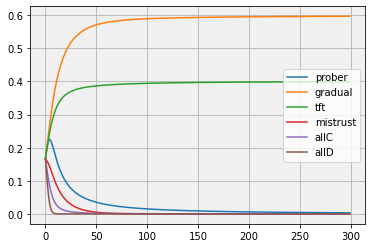

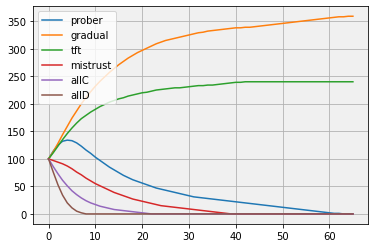

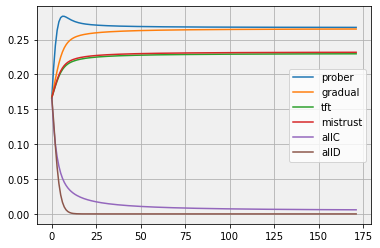

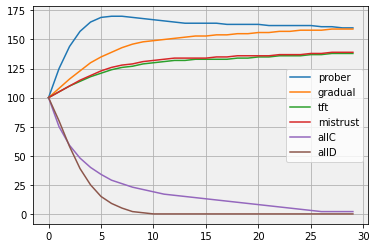

In [7]:
bag=bag6
m1 = Tournament(g,bag,length=100)
m1.run()

m2 = EvolDeterReal('ind', m1 , np.array([1/6]*6), 300, '')
m2.run()
m2.drawPlot()

m2 = EvolDeterInt('ind', m1, 100 , 100, '')
m2.run()
m2.drawPlot()

m2sr = EvolDeterReal('com', m1, np.array([1/6]*6), 300, '')
m2sr.run()
m2sr.drawPlot()

m2sr = EvolDeterInt('com', m1 , 100, 100, '')
m2sr.run()
m2sr.drawPlot()


On note que la détection de la convergence dans le cas Reel n'est pas évidente. Il y a toujours un léger écart. Tandis que la version entiere assure un calcul parfait.

# Fréquence des points de convergence 
# Frequency of convergence points

# Tableau 1  
## Convergence vers la coopération généralisée du modèle évolutionnaire individualiste 
## Convergence to the generalized cooperation of the individualistic evolutionary model 

On prend 1000 fois de 4 à 10 stratégies au hasard dans le bag, et on évalue le nombre de fois où il y a convergence vers la coopération généralisée : TRES LONG A CHAQUE FOIS

In [ ]:
synthese=[]
# 4 familles étudiées, 1 ligne par famille
for bagFamily in [bag20 , bag20+bagDyson, getMem(1,1), getMem(1,2), getMem(2,1)] :
#for bagFamily in [getMem(1,2), getMem(2,1)] :
    ligne=[]
    # 7 tailles de bag étudiées, 1 par colonne
    print('+' ,end='')
    for nb in range(4,11):
        nbCpcCooperations=0
        print('.' , end='')
        # 100 exp au hasard à chaque fois
        for i in range(0, 1000):                  # <====   CHANGER ICI PAR 1000
            bag =  random.sample(bagFamily, nb)
            #if len(bagFamily)>31 :
            #    bag=bag+ [Tft(),Gradual(),Spiteful()] 
            m1 = Tournament(g,bag,length=100)
            m1.run()
            m2 = EvolDeterInt('com',m1,[100]*len(bag),10000,'')
            m2.run()
            if  m2.cooperationList[-1] == 100.0 :
                nbCpcCooperations=nbCpcCooperations+1
            #else :
                # on affiche le probleme
                #print([s.name for s in bag],"\t",str(m2.cooperationList[-1] ))
        ligne.append(nbCpcCooperations)
    synthese.append(ligne)
print()
df = pd.DataFrame(synthese , columns=list(range(4,11)) , index=['bag20','bag20+Dyson', 'mem11++','mem12++','mem21++'] )
#pd.DataFrame(synthese , columns=list(range(4,11)) , index=['mem12','mem21'] )
df['moy']=df.mean(axis=1)  # ajout d'une colonne
#df.loc['moy'] = df.mean(axis=0) # ajout d'une ligne
df


# Tableau 2 :
## Proportion d'attracteurs uniques pour le modèle évolutionnaire communautaire 
## Proportion of unique attractors for the community evolutionary model

In [ ]:
def evolReels(population,scores,iter):
    for i in range(iter):
        # print([s.name for s in bag] , population)
        fitness = population*np.dot(scores,population)
        population = fitness/sum(fitness)
    return population


def testAttracteur(bag, algo='com'):
    nbstrats = len(bag)
    m1 = Tournament(g,bag,length=100)
    m1.run()
    scores = m1.matrix.iloc[0:nbstrats,0:nbstrats].values
    if (algo=='com'):
        for i in range(nbstrats) : scores[i,i]=0
    #===== generer dans pops 4 points de depart différents
    pops=[]
    # 1000 et les autres à 100
    for i in range(len(bag)) :
        p1=[100]*len(bag)
        p1[i]=1000
        pops.append(p1)
    # tous egaux,
    #pops.append([100]*nbstrats)
    # tous croissants,
    #pops.append( [(i+1)*100 for i in range(nbstrats)] )
    # tous décroissants
    #pops.append( [i*100 for i in range(nbstrats,0,-1)] )
    # aleatoire ... 10 fois
    #for i in range(10) :
    #    pops.append( [random.randint(1,10)*100 for i in range(nbstrats)] )
    #=====  Pour tous ces cas, calculer le vecteur resultat de l'iteration de 1000 etapes
    histo=[]
    for pop in pops :
        result = evolReels(np.array(pop)/sum(pop) ,scores, 100)
        # A remplacer par 
        # evol = EvolDeterReal(algo,m1,np.array(pop)/sum(pop), 100,'')
        # histo.append(evo.historic[-1])
        histo.append(result)
    #===== Calculer si convergence unique ou pas    
    y = np.std(histo, axis=0)
    if list(filter(lambda x : x >0.001 , y)) != [] :
    #if sum(y) > 0.01 :   # somme des ecart-types > 1/100è => surement plusieurs attracteurs
        # print(y, [s.name for s in bag] )
        # print(histo)
        return 0
    else :
        #return 1
        # print(histo[-1], [s.name for s in bag] )
        # Et si on veut cumuler les 2 calculs Convergence + 100% coop
        m2 = EvolDeterInt(algo,m1,100,10000,'')
        m2.run()
        if (m2.cooperationList[-1] == 100.0) :
            #print(histo[-1], [s.name for s in bag] )
            return 1
        else :
            return 0
        


print(testAttracteur(bag6,'com') ) # -> 1  donc 1 seul attracteur
testAttracteur([Mistrust(),Prober(),SpitefulCC(),HardTft()],'com')   # -> 0 # donc plusieurs attracteurs



In [ ]:
synthese=[]
# 5 familles étudiées, 1 ligne par famille
for bagFamily in [bag20, bag20+bagDyson, getMem11() , getMem(1,2) , getMem(2,1)] :
    ligne=[]
    # 7 tailles de bag étudiées, 1 par colonne
    print('+',end='')
    for nb in range(4,11):
        print('.',end='')
        nbAttracteursUniques=0
        # 1000 exp au hasard à chaque fois
        for i in range(0, 1000):                 # <===== CHANGER ICI
            bag =  random.sample(bagFamily, nb)
            nbAttracteursUniques = nbAttracteursUniques + testAttracteur(bag,'ind')
        ligne.append(nbAttracteursUniques)
    synthese.append(ligne)
print()
df=pd.DataFrame(synthese , columns=list(range(4,11)) , index=['bag20', 'bag20+dyson','mem11','mem12','mem21'] )

df['moy']=df.mean(axis=1)  # ajout d'une colonne
# df.loc['moy'] = df.mean(axis=0) # ajout d'une ligne
df

# Tableau 3 : 
## Dissimilarité dans les classements
## Dissimilarity in rankings

In [ ]:
# compare les classements entre m2 et m2sr
# plus la note est faible , plus les classements sont proches
def testClassements(bag):
    m1=Tournament(g,bag,100)
    m1.run()
    #
    m2=EvolDeterInt('ind',m1, [100]*len(bag) ,10000,'', strict=True, resilience=0.0)
    m2.run()
    df1=pd.DataFrame(m2.historic[-1], index=m2.nomstrats,columns=['ind']).sort_values(by='ind',ascending=False)
    df1['rank_ind'] = df1['ind'].rank(axis=0, ascending=False, method='average')
    #
    m2sr=EvolDeterInt('com', m1, [100]*len(bag) ,10000,'', strict=True, resilience=0.0)
    m2sr.run()
    df2=pd.DataFrame(m2sr.historic[-1], index=m2sr.nomstrats,columns=['com']).sort_values(by='com',ascending=False)
    df2['rank_com'] = df2['com'].rank(axis=0, ascending=False , method='average')
    #
    result = pd.concat([df1,df2] , axis=1)
    n = len(bag)
    # calcul 1 : avec les valeurs absolues
    #result['ecart1']=abs(result['rank_m2']-result['rank_m2sr'])
    #norme = (2*n**2 + (-1)**n -1)/4
    #note1 = result['ecart1'].sum()  / norme
    # calcul 2 : carre des ecarts
    result['ecart2']=(result['rank_ind']-result['rank_com'])**2
    note2= 1-(6*sum(result['ecart2'])) / (n**3 - n)
    # Calcul 3 : Spearman boite noire
    #spearman = result['rank_m2'].corr(result['rank_m2sr'], method='spearman')  # ou pearson ou kendall
    if np.isnan(note2) :  #  quand tous sont égaux, spearman n'est pas défini
        print(result)
    return note2
    

testClassements(bag4)

In [ ]:
synthese=[]
# 5 familles étudiées, 1 ligne par famille
for bagFamily in [bag20, bag20+bagDyson, getMem11() , getMem(1,2) , getMem(2,1)] :
    ligne=[]
    # 7 tailles de bag étudiées, 1 par colonne
    print('+',end='')
    for nb in range(4,11):
        print('.',end='')
        notes=[]
        # 1000 exp au hasard à chaque fois
        for i in range(0, 2):                 # <===== CHANGER ICI
            bag =  random.sample(bagFamily, nb)
            #if len(bagFamily)>31 :
            #    bag=bag+ [Tft(),Gradual(),Spiteful()] 
            notes.append(testClassements(bag))
        ligne.append(np.mean(notes))   # quand tous sont égaux, spearman est non défini : on le saute
    synthese.append(ligne)
print()

df= pd.DataFrame(synthese , columns=list(range(4,11)) , index=['bag20', 'bag20+dyson','mem11','mem12','mem21'] )
df=50*(df+1)   # SIMI
df['moy']=df.mean(axis=1)  # ajout d'une colonne
df.loc['moy'] = df.mean(axis=0) # ajout d'une ligne
df


# Tableau 4 : 
## Comparaison basée sur le cumul des classements
## Comparison based on cumulative rankings
Comparaison des classements.
Pour n bags différents, chacun sur une ligne, on affiche un tableau montrant pour 1000 sous-ensembles de 4 à 7 stratégies différents prises aléatoirement dans ces bags en colonne, le nombre de fois où une stratégie a été classée premiere.

In [ ]:
synthese=[]
# 5 familles étudiées, 1 ligne par famille
for bagFamily in [bag20]: #, bag20+bagDyson, getMem11() , getMem(1,2) , getMem(2,1)] :
    result=pd.DataFrame(index=[s.name for s in bagFamily])
    result['cumul']=0
    result['rank']=0
    # 7 tailles de bag étudiées, 1 par colonne
    print('+',end='')
    for nb in range(4,11):
        print('.',end='')
        # 1000 exp au hasard à chaque fois
        for i in range(0, 1000):                 # <===== CHANGER ICI
            bag =  random.sample(bagFamily, nb)
            #if len(bagFamily)>31 :
            #    bag=bag+ [Tft(),Gradual(),Spiteful()] 
            # on fait le tournoi
            m1=Tournament(g,bag,100)
            m1.run()
            # on fait la compet ecolo
            m2=EvolDeterInt('com',m1, [100]*len(bag) ,10000,'', strict=True, resilience=0.0)
            m2.run()
            # Je cree un Dataframe avec la derniere ligne
            df=pd.DataFrame(m2.historic[-1], index=m2.nomstrats,columns=['pops']) # .sort_values(by='pops',ascending=False)
            # je calcule le classement, et rajoute la colonne
            df['rank'] = df['pops'].rank(axis=0, ascending=False, method='min')
            # Soit on ne garde que les 1
            df['rank'] = np.where(df['rank'] != 1, 0 , df['rank']) 
            # Soit on cumule les scores
            #df['rank'] = nb+1-df['rank']
            # on rajoute cette colonne au result pour pouvoir cumuler
            result.drop('rank',axis=1, inplace=True)
            result = result.join(df['rank'], how='left')
            result['cumul'] = result.sum(axis=1)   #['cumul'] + result['rank']
            
    #result2 = pd.DataFrame(result.sum(axis=1), columns=['somme'])
    #result2.sort_values(by='somme',ascending=False ,inplace=True)
    result.drop('rank',axis=1, inplace=True)
    result.sort_values(by='cumul',ascending=False ,inplace=True)
    print(result)


## Calcul du polygone de convergence
## Computation of the polygon of convergence

In [ ]:
plt.figure(figsize=(10,10))

def draw_polygon(bag,algo,nb,prefix) :
    # nb : liste de valeurs de population courante, avec 1 seul à 1000
    m1=Tournament(g,bag,100)
    m1.run()
    
    # tracé du polygone
    fig = plt.figure(figsize=(10, 10))
    nbstrats = len(m1.strategies)
    xs=[]
    ys=[]
    for k in range(nbstrats) :
        xs.append(np.sin(k*2*np.pi/nbstrats))
        ys.append(np.cos(k*2*np.pi/nbstrats))
        plt.text(np.sin(k*2*np.pi/nbstrats) , np.cos(k*2*np.pi/nbstrats) ,m1.matrix.columns[k] , size='xx-large')
    plt.plot(xs+xs[:1], ys+ys[:1])

    # LES POPULATIONS
    pops=[]

    # generees au hasard
    #nbpops=50     # <=====  CHANGER ICI
    #for i in range(nbpops) :
    #    pops.append( [1+random.randint(1,10) for i in range(nbstrats)] )

    
    # generees à partir des bords
    for n in nb :
        for i in range(len(bag)) :
            p1=[n]*len(bag)
            p1[i]=1000
            # p1[random.randrange(len(bag))]=1000
            pops.append(p1)
 
    # Par les combinaisons de [100,200,300,1000] pour chaque strategies ... 4^6 pour 6 stratégies
    #pops=list( map(list, it.product([10,200,1000], repeat=6)))    
    
    # Calcul des trajectoires    
    for pop in pops :
        # m2=EvolDeterReal(algo,m1,np.array(pop)/sum(pop), 10000, '', resilience=0)
        m2=EvolDeterInt(algo,m1,pop,1000,'',resilience=0)
        m2.run()
        # print("duree d'evolution ",len(m2.historic))
        # Trace des convergences dans le cas Reel : print(m2.historic[-1])
        # print("taux coop final en entiers : ",m2.cooperationList[-1])
        df = pd.DataFrame(m2.historic, columns=m2.nomstrats)
        for i in range(df.shape[0]) :
            # df.loc[i,'abs']= sum(np.array(df.loc[i])[0:3] * [a,b,c])  / sum(df.loc[i][0:3])
            df.loc[i,'abs']= np.inner(np.array(df.loc[i])[0:nbstrats] , xs)  / sum(df.loc[i][0:nbstrats])
            df.loc[i,'ord']= sum(np.array(df.loc[i])[0:nbstrats] * ys) / sum(df.loc[i][0:nbstrats])
            plt.plot(df.iloc[-1,-2],df.iloc[-1,-1], 'bo')
        plt.plot(df['abs'], df['ord'])
    # eventuellement on retrace le dernier point s'il est effacé             
    plt.plot(df.iloc[-1,-2],df.iloc[-1,-1], 'bo')

    tmillis = int(round(time.time() * 1000))  
    plt.axis('off')
    plt.savefig(prefix+'_polygon_'+algo+'_'+str(nb)+'_'+str(tmillis) , dpi=500)
    plt.show()
    plt.close()
    
# ======================================================================

bag = bag4
draw_polygon(bag, 'ind', [20,50,100], 'fig7_bag4_polyone_Entier')
#draw_polygon([Periodic('C','allC'), Periodic('D','allD'), Prober(), SoftMajority(),Mistrust()], 'm2', [20], 'fig8_bagX')


Attention : avec la version Entiere il y a (en général) plusieurs points de convergence, avec la version Reel il n'y en n'a (en général) qu'un seul.

## Nouveau graphique : les barres

On enleve la meilleure à chaque fois puis on trace les évolutions de chacune.

In [ ]:
# plt.figure(figsize=(10,10))

def draw_barres(bag,algo,prefix) :
    m1=Tournament(g,bag,100)
    m1.run()
    l=[]   # liste des coeff finaux
    popinit = np.array([100]*len(bag))
    for i in (range(len(bag)-1)):
        #print("etape",i)
        pop=popinit.copy()/sum(popinit)   # on recalcule le pourcentage à chaque fois
        #print(pop)
        m2=EvolDeterReal(algo,m1, pop,1000,'', resilience=0.0)
        m2.run()
        lig = m2.historic[-1].copy()
        # print(lig)
        l.append(lig) # on rajoute les coeffs à la liste
        max=np.argmax(lig)    # on enleve le max
        # pour le min, il faut utiliser un masked_array
        #lig2 = np.ma.MaskedArray(lig, lig<=0)
        #max=np.ma.argmin(lig2)
        # print(max,'ème mis à zero')
        #print()
        popinit[max]=0
    # traitement de la derniere famille restante
    #lig=[0]*len(bag)
    #lig[popinit.argmax()]=1
    #print("dernier classement : ",lig)
    #l.append(lig)
    
    result = pd.DataFrame(l, columns=m1.matrix.index.values)
    result=result.replace(0.0,np.nan)
    #print(result)
    result.plot(style='o-', figsize=(10,6), ylim=(0,np.max(l)) )
    plt.vlines(list(range(len(bag)-1)),ymin=0, ymax=1, colors='k')
    
    tmillis = int(round(time.time() * 1000))    
    plt.savefig(prefix+'_barres_'+algo+'_'+str(tmillis) , dpi=500)
    plt.show()
    plt.close()


# ======================================================================

draw_barres(bag11, 'ind', 'bag11')

## Refaire une ou plusieurs exp classiques

In [ ]:
bag=bag5
m1=Tournament(g,bag,100)
m1.run()

pops=[]
# tous egaux,
pops.append([100]*len(bag))
# tous croissants,
pops.append( [(i+1)*100 for i in range(len(bag))] )
# tous décroissants
pops.append( [i*100 for i in range(len(bag),0,-1)] )
# aleatoire ... 
#pops.append( [random.randint(1,10)*100 for i in range(len(bag))] )
#  A la main ...
#pop=[10]*20
#pop[0]=1000

for pop in pops :
    m2=EvolDeterInt('ind',m1,pop,1000,'', strict=True, resilience=0.0)
    #m2=M2Reels(m1,'',np.array(pop)/sum(pop),10000,'m2', resilience=0)

    m2.run()
    m2.drawPlot()
    #print("%coop :", m2.cooperationList[-1])
    print("stab at : ", len(m2.historic))
    print("valeurs initiales : ",pop)
    print("valeurs finales : ",m2.historic[-1])
    # Classements
    df = pd.DataFrame(m2.historic, columns=m2.nomstrats)
    print(df.iloc[-1].sort_values(ascending=False))

## Regenerer 96 courbes  représentatives

In [ ]:
plt.figure(figsize=(10,10))

names=['bag4', 'bag5', 'bag6', 'bag11', 'bag20', 'bag20Dyson', 'Mem11']
for idx, bag in enumerate([bag4, bag5, bag6, bag11, bag20, bag20+bagDyson, getMem11()]) :
    for algo in ('ind','com') :
        m1=Tournament(g,bag,100)
        m1.run()
        m2=EvolDeterInt(algo,m1,names[idx]+'_constant_',[100]*len(bag),1000,'', strict=True, resilience=0)
        m2.run()
        m2.plot()
        m2=EvolDeterInt(algo,m1,names[idx]+'_croissant_',[(i+1)*100 for i in range(len(bag))],1000,'', strict=True, resilience=0)
        m2.run()
        m2.plot()
        m2=EvolDeterInt(algo,m1,names[idx]+'_decroissant_',[i*100 for i in range(len(bag),0,-1)],1000,'', strict=True, resilience=0)
        m2.run()
        m2.plot()
        draw_polygon(bag, algo, [1], names[idx])
        draw_polygon(bag, algo, [10], names[idx])
        draw_polygon(bag, algo, [100], names[idx])
        draw_barres(bag, algo, names[idx])

## Comment regénérer les courbes de l'article ?
## How to regenerate the drawings of the paper ?

In [ ]:
# fig1
bag = bag4
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig1_bag4', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig1_bag4', strict=True, resilience=0.25)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig1_bag4' strict=True, resilience=0.5)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig1_bag4', strict=True, resilience=0.75)
ind.run()
ind.plot()

# fig2
bag = bag6
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('ind',m1,[100]*len(bag),5000,'fig2_bag6', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),5000,'fig2_bag6', strict=True, resilience=0.25)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),5000,'fig2_bag6', strict=True, resilience=0.5) # VERIFIER 1201
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[100]*len(bag),5000,'fig2_bag6', strict=True, resilience=0.75)  # VERIFIER 2697
ind.run()
ind.plot()


# fig3
bag = bag6
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig3_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,'fig3_bag6_croissant',[(i+1)*100 for i in range(len(bag))],1000,'fig3_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,'fig3_bag6_decroissant',[i*100 for i in range(len(bag),0,-1)],1000,'fig3_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()

# fig4
bag = bag6
draw_polygon(bag, 'ind', [20,50,100], 'fig4_bag6')

# fig5
bag = bag20
draw_polygon(bag, 'ind', [10], 'fig5_bag20')

# fig6
bag = bag4
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig6_bag4_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[(i+1)*100 for i in range(len(bag))],1000,'fig6_bag4_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[i*100 for i in range(len(bag),0,-1)],1000,'fig6_bag4_constant', strict=True, resilience=0)
ind.run()
ind.plot()

# fig7
bag = bag4
draw_polygon(bag, 'ind', [20, 50,100], 'fig7_bag4')

# fig8
draw_polygon([Periodic('C','allC'), Periodic('D','allD'), Prober(), SoftMajority(),Mistrust()], 'ind', [20], 'fig8_bagX')

# fig9
bag = bag5
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('ind',m1,[100]*len(bag),1000,'fig9_bag5_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[(i+1)*100 for i in range(len(bag))],1000,'fig9_bag5_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('ind',m1,[i*100 for i in range(len(bag),0,-1)],1000,'fig9_bag5_constant', strict=True, resilience=0)
ind.run()
ind.plot()
pop=[100]*len(bag)
ind=EvolDeterReal('ind',m1,np.array(pop)/sum(pop),10000,'fig9_bag5_constant')   # pourquoi si j'ajoute resilience ça cree une ERR
ind.run()
ind.plot()
pop=[(i+1)*100 for i in range(len(bag))]
ind=EvolDeterReal('ind',m1,np.array(pop)/sum(pop),10000,'fig9_bag5_constant')   # pourquoi si j'ajoute resilience ça cree une ERR
ind.run()
ind.plot()
pop=[i*100 for i in range(len(bag),0,-1)]
ind=EvolDeterReal('ind',m1,np.array(pop)/sum(pop),10000,'fig9_bag5_constant')   # pourquoi si j'ajoute resilience ça cree une ERR
ind.run()
ind.plot()

# fig10
# Pour la Fig10 il faut faire un polygon avec indReel ce qui oblige à changer le code de Polygon
draw_polygon(bag, 'ind', [100], 'fig10_bag5_Entier')
#draw_polygon(bag, 'ind', [100], 'fig10_bag5_Reel')




# fig11
bag = bag11
draw_barres(bag, 'ind', 'fig11_bag11')


#====================   com ======================

# fig12
bag = bag6
m1=Tournament(g,bag,100)
m1.run()
ind=EvolDeterInt('com',m1,[100]*len(bag),1000,'fig12_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('com',m1,[(i+1)*100 for i in range(len(bag))],1000,'fig12_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()
ind=EvolDeterInt('com',m1,[i*100 for i in range(len(bag),0,-1)],1000,'fig12_bag6_constant', strict=True, resilience=0)
ind.run()
ind.plot()

# Fig13
draw_polygon(bag, 'com', [10,100], 'fig13_bag6_Entier')


# fig14
bag = bag11
draw_barres(bag, 'com', 'fig14_bag11')
